## Comparación de algoritmos Transformer para evaluar su rendimiento frente a la baseline (MLP) y similares

En este fichero vamos a realizar una serie de pruebas para comprobar el funcionamiento de los algoritmos transformer (probaremos 2 o 3 algoritmos).

La comparación se realizará entre estos, 
- #### MLP --> Lo marcaremos como baseline
- #### XGBoost
- #### TabNet
- #### TabTransformer

Como el problema de clasificación es del tipo binario vamos a utilizar las siguientes métricas, 
- #### Accuracy
- #### F1-Score
- #### ROC-AUC
- #### Tiempo de entrenamiento 
- #### Pérdida en el entrenamiento

Para cada modelo realizaré los imports y el preprocesado hasta lograr como mínimo una puntuación superior a la baseline que nos vamos a marcar con el MLP

In [10]:
# Vamos a importar el fichero y ver su formato
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
file = pd.read_csv('Data/mushroom_cleaned.csv', sep=',')
print(file.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54035 entries, 0 to 54034
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cap-diameter     54035 non-null  int64  
 1   cap-shape        54035 non-null  int64  
 2   gill-attachment  54035 non-null  int64  
 3   gill-color       54035 non-null  int64  
 4   stem-height      54035 non-null  float64
 5   stem-width       54035 non-null  int64  
 6   stem-color       54035 non-null  int64  
 7   season           54035 non-null  float64
 8   class            54035 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 3.7 MB
None


### MLP 

Esta va a ser la baseline, es decir que todos los siguientes resultados para que sean considerados una solución aceptable deben ser como mínimo mejores a esta.

#### Bloque código + Entrenamiento

In [17]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, classification_report, confusion_matrix
import time

# Separamos los datos en features y target
X = file.drop('class', axis=1)
y = file['class']

# Separamos los datos en train-test-validation
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=.5, random_state=42)

# Aplicamos una estandarización usando el scaler
scaler = StandardScaler()
X_train_scaled  = scaler.fit_transform(X_train)
X_val_scaled    = scaler.fit_transform(X_val)
X_test_scaled   = scaler.fit_transform(X_test)

# Creamos el modelo de perceptron multicapa
mlp = MLPClassifier(hidden_layer_sizes=(64,32), activation='relu', solver='adam', max_iter=50, random_state=42)

# Entrenamos el modelo
ttime_MLP = time.time()
mlp.fit(X_train_scaled, y_train)
ttime_MLP = time.time() - ttime_MLP # Con esto sacamos el valor para poder comparar los tiempo de entrenamiento entre estos

# Sacamos las predicciones
y_val_pred          = mlp.predict(X_val_scaled)
y_test_pred         = mlp.predict(X_test_scaled)
y_val_pred_proba    = mlp.predict_proba(X_val_scaled)[:,1]
y_test_pred_proba   = mlp.predict_proba(X_test_scaled)[:,1]

# Ahora calculamos las métricas
mlp_val_accuracy    = accuracy_score(y_val, y_val_pred)
mlp_test_accuracy   = accuracy_score(y_test, y_test_pred)
mlp_val_f1          = f1_score(y_val, y_val_pred)
mlp_test_f1         = f1_score(y_test, y_test_pred)
mlp_val_roc_auc     = roc_auc_score(y_val, y_val_pred_proba)
mlp_test_roc_auc    = roc_auc_score(y_test, y_test_pred_proba)
mlp_conf_matrix     = confusion_matrix(y_test, y_test_pred)

# Sacamos la training loss y el tiempo por écpoa
mlp_loss_curve = mlp.loss_curve_
mlp_time_epoch = ttime_MLP / len(mlp_loss_curve)

# Sacamos los valores de la curva ROC
mlp_fpr, mlp_tpr, _ = roc_curve(y_test, y_test_pred_proba)

# Hacemos el objeto métricas para el display
mlp_metricas = {
    "Validation Accuracy"   : [mlp_val_accuracy],
    "Test Accuracy"         : [mlp_test_accuracy],
    "Validation F1-Score"   : [mlp_val_f1],
    "Test F1-Score"         : [mlp_test_f1],
    "Validation ROC AUC"    : [mlp_val_roc_auc],
    "Test ROC AUC"          : [mlp_test_roc_auc],
    "Training Time"         : [ttime_MLP],
    "Time \ Epoch "         : [mlp_time_epoch],
    "Confusion Matrix"      : [mlp_conf_matrix]
}

x:\Repos\alejandromadrid\.python-transformer-venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Bloque Display

   Validation Accuracy  Test Accuracy  Validation F1-Score  Test F1-Score  \
0             0.974213       0.976437             0.976328       0.978695   

   Validation ROC AUC  Test ROC AUC  Training Time  Time \ Epoch   \
0            0.996645      0.996494       7.154807       0.143096   

            Confusion Matrix  
0  [[3528, 103], [88, 4387]]  


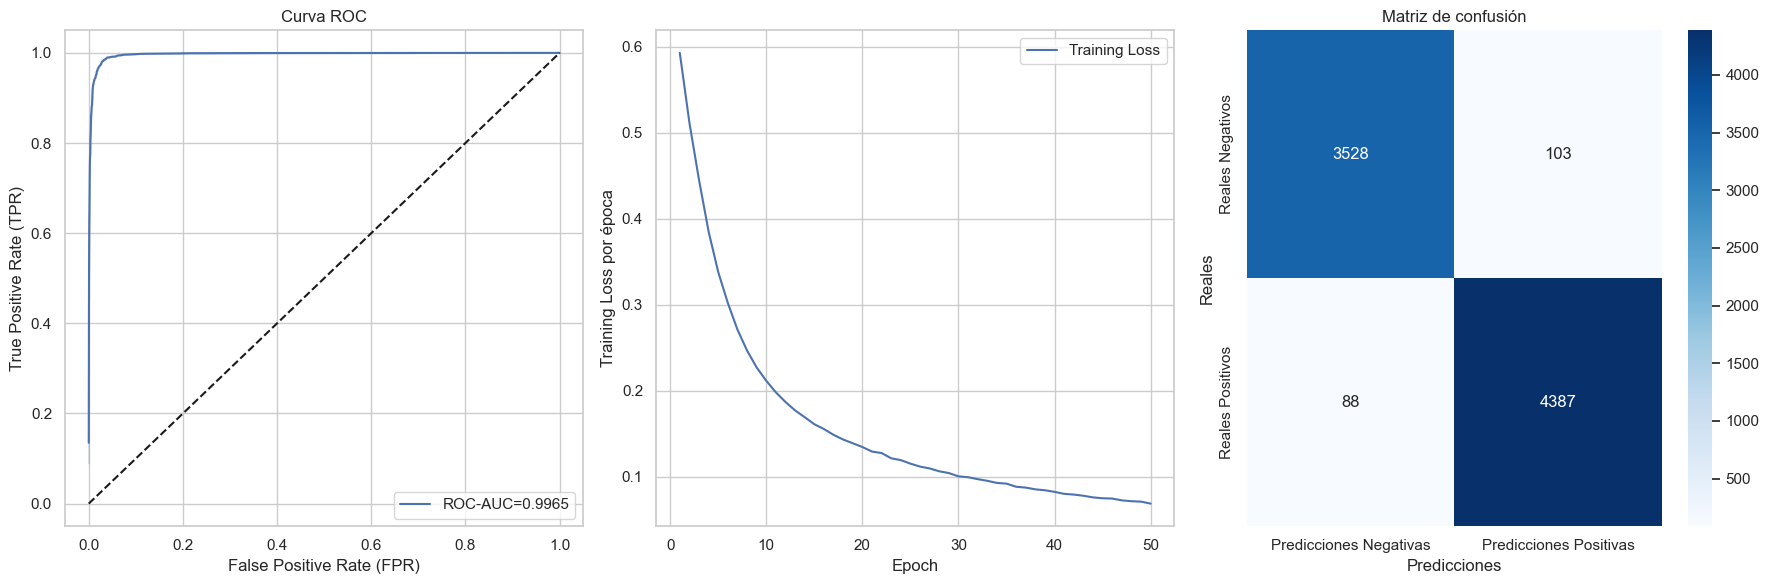

In [19]:
mlp_df = pd.DataFrame(mlp_metricas)
print(mlp_df)

# Creamos los plots para la roc-curve y la pérdida por época en seaborn

sns.set_theme(style="whitegrid")

plt.figure(figsize=(18,6))
# Plot para la curva roc
plt.subplot(1,3,1)
sns.lineplot(x=mlp_fpr, y=mlp_tpr, label=f'ROC-AUC={mlp_test_roc_auc:.4f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
# Plot para la pérdida por época
plt.subplot(1,3,2)
epocas = list(range(1, len(mlp_loss_curve) + 1))
sns.lineplot(x=epocas, y=mlp_loss_curve, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss por época')
plt.legend(loc='upper right')
# Plot para la matriz de confusión
plt.subplot(1,3,3)
sns.heatmap(mlp_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicciones Negativas', 'Predicciones Positivas'], yticklabels=['Reales Negativos', 'Reales Positivos'])
plt.xlabel('Predicciones')
plt.ylabel('Reales')
plt.title('Matriz de confusión')
#
plt.tight_layout()
plt.show()

Voy a pasar los datos a markdown para evitar que en futuras reejecuciones cambien los resultados:

| Métrica                 | Valor           |
|-------------------------|-----------------|
| Precisión Validación    | 97.41%          |
| Precisión Prueba        | 97.67%          |
| F1 Score Validación     | 97.62%          |
| F1 Score Prueba         | 97.89%          |
| ROC AUC Validación      | 99.67%          |
| ROC AUC Prueba          | 99.66%          |
| Tiempo Entrenamiento    | 48.77 segundos  |
| Tiempo por Época        | 0.98 segundos   |


Ahora que tenemos la tabla, podemos marcar como una baseline para este problema esta ejecución, el objetivo de este documento es comparar diferentes métodos tanto en las métricas comentadas como en la performance de los algoritmos buscando una comparación entre algoritmos del tipo transformer para datos tabulares como con el que estamos trabajando

### XGBoost